In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from typing import *

tfb = tfp.bijectors
tfd = tfp.distributions
SEED = 42
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")

### Change of variables numerical

This code shows the what happens if you take uniform distributed data and square it.  

Text(0.5, 0, 'z')

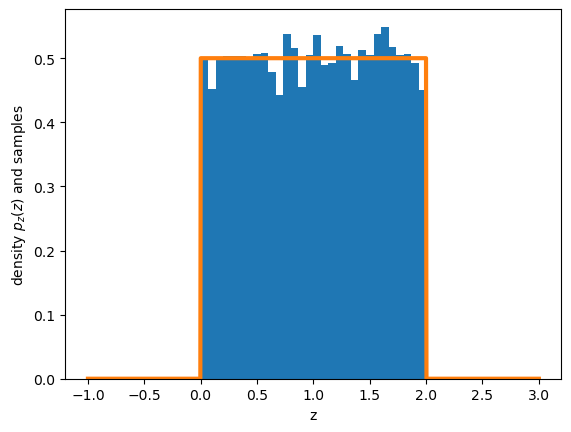

In [4]:
N = 10000

d = tfd.Uniform(low=0, high=2)
zs = d.sample(N, seed=SEED)

plt.hist(zs, density=True, bins=30)
zd = np.linspace(-1, 3, 1000)
plt.plot(zd, d.prob(zd), linewidth=3)

plt.ylabel('density $p_z(z)$ and samples')
plt.xlabel('z')

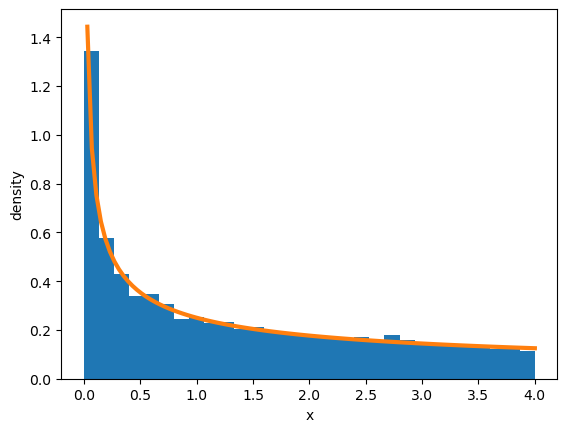

In [6]:
x = zs**2
plt.hist(x, density=True, bins=30)
plt.ylabel('density')
plt.xlabel('x')
xs = np.linspace(0.03, 4, 100)
plt.plot(xs, 1./(4 * np.sqrt(xs)), linewidth=3)
plt.show()

In [7]:
g = tfb.Square()       # This is a bijector
print(g.forward(2.0))  #4
print(g.inverse(4.0))  #2

tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [11]:
chain = tfb.Chain([tfb.Square(), tfb.Square()], name="x4")
print(chain.forward(2.0))
print(chain.inverse(256.0))

tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)


(0.0, 1.0)

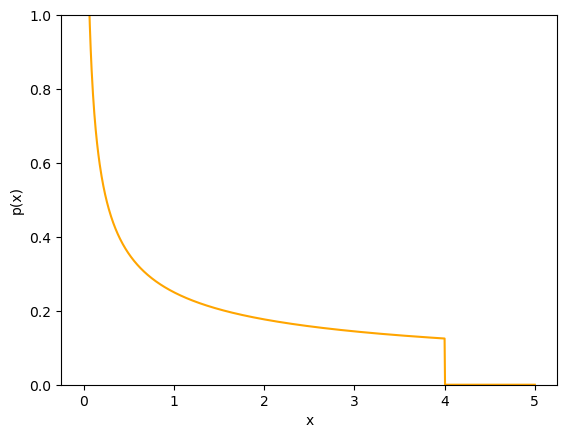

In [9]:
base_dist = tfd.Uniform(0.0, 2.0)
mydist = tfd.TransformedDistribution(distribution=base_dist, bijector=g)  #My dist is a new distribution

xs = np.linspace(0.001, 5, 1000)
px = mydist.prob(xs) 

plt.plot(xs, px, color="orange")
plt.xlabel('x')
plt.ylabel('p(x)')
plt.ylim(0,1)

# Training Bijectors

An extremly simple example, to go from a $N(0,1)$ Gaussian to a $N(5.0,0.2)$ Gaussian. 

#### Training Data
Let's sample some training data of our traget distribution:

(1000, 1)

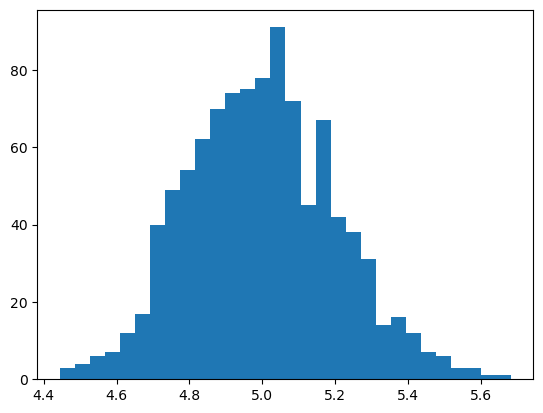

In [12]:
N = 1000
X = tfd.Normal(loc=5, scale=0.2).sample(1000, seed=SEED)
X = X.numpy()[:, np.newaxis]
plt.hist(X, 30)
X.shape

#### The simplest flow 


Building the flow using an Affine transformation in 1-D. Simply shift ($b$) and scale ($a$).

$$
    x = a \cdot z + b
$$


In [28]:
b = tf.Variable(0.0, name="bias")
a = tf.Variable(1.0, name="weight")
bijector = tfb.Chain([tfb.Shift(b), tfb.Scale(a)])
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0, scale=1), bijector=bijector)
dist.trainable_variables

(<tf.Variable 'bias:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'weight:0' shape=() dtype=float32, numpy=1.0>)

In [29]:
-K.mean(dist.log_prob(X)) #The NLL of the whole training set

<tf.Tensor: shape=(), dtype=float32, numpy=13.432692>

#### Training in eager mode

What shall be the result? 

$z \sim N(0,1) \overbrace{\longrightarrow}^{g(z) = a\cdot z + b} x \sim N(5,0.2)$. 

Hence, $b = 5$ and $a = 0.2$

In [30]:
optimizer = Adam(learning_rate=0.1) #quite high lr for normalizing flows.

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -K.mean(dist.log_prob(X)) #<-- The negative log-likelihood we want to minize 
        gradients = tape.gradient(loss, dist.trainable_variables)     
    optimizer.apply_gradients(zip(gradients, dist.trainable_variables)) #E     
    if (i % 100 == 0):
        print(i, "NLL ",loss.numpy(), " weight ", a.numpy(), " bias ", b.numpy())

0 NLL  13.432692  weight  1.100003  bias  0.10000292
100 NLL  1.9116402  weight  2.4516315  bias  3.9803116
200 NLL  0.256368  weight  0.41906998  bias  4.9998455
300 NLL  -0.17798384  weight  0.20253186  bias  4.998628
400 NLL  -0.1779885  weight  0.2025157  bias  4.998649
500 NLL  -0.17798859  weight  0.20251793  bias  4.9986486
600 NLL  -0.17798848  weight  0.20251788  bias  4.998649
700 NLL  -0.17798848  weight  0.20251788  bias  4.9986496
800 NLL  -0.17798851  weight  0.2025179  bias  4.9986496
900 NLL  -0.17798854  weight  0.2025179  bias  4.998649


#### Visualizing the learnd distribution 
We now compare the learned flow and the original data

Text(0.5, 0, 'x')

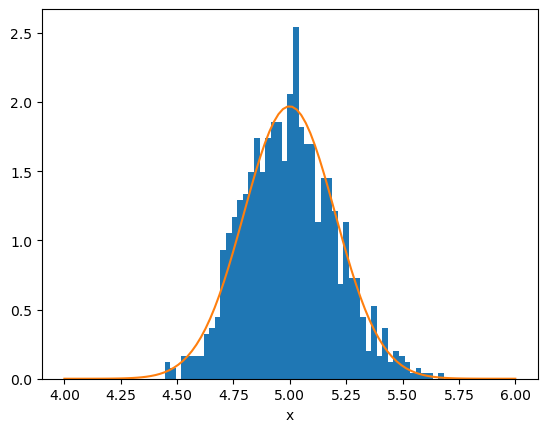

In [31]:
xx = np.linspace(4, 6,100)
plt.hist(X, bins=50,density=True)
plt.plot(xx, dist.prob(xx) )
dist.trainable_variables
plt.xlabel('x')

## Non-Linearity

The SinhArcsinh Bijector has a complicated name but looks quite promising: it has two parameters skewness and tailweight and if tailweight>0 there are no restrictions on x and z. In the following we plot that Bijector for some parameters.

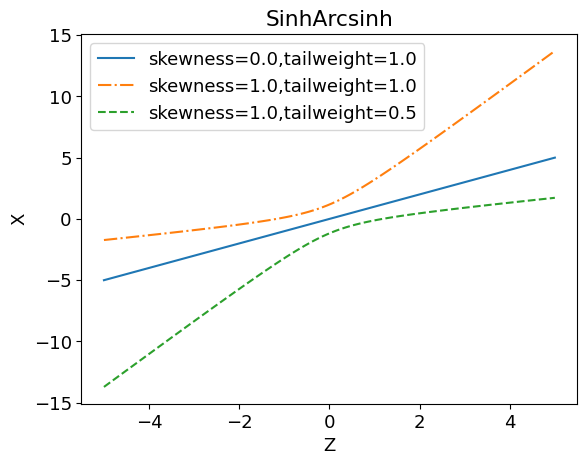

In [37]:
plt.rcParams.update({'font.size': 13}) #Macht grosse axen
zs = np.linspace(-5, 5, 100, dtype=np.float32)
plt.plot(zs, tfb.SinhArcsinh(skewness=0.0, tailweight=1.0).forward(zs))
plt.plot(zs, tfb.SinhArcsinh(skewness=1.0, tailweight=1.0).forward(zs),linestyle='-.')
plt.plot(zs, tfb.SinhArcsinh(skewness=-1.0, tailweight=1.0).forward(zs),linestyle='--')
plt.xlabel('Z')
plt.ylabel('X')
plt.title('SinhArcsinh')
plt.legend(['skewness=0.0,tailweight=1.0','skewness=1.0,tailweight=1.0','skewness=1.0,tailweight=0.5'])
plt.savefig('ch06_sin.pdf')

## Fitting the old faithful

Finally we can start to deal with real world data such as the old-faithful geyser. 

(272, 1)

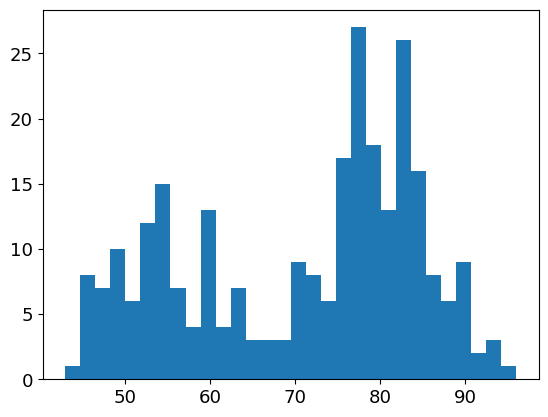

In [42]:
df = pd.read_csv(os.path.join(data_path, 'faithful.csv'))
X = df["waiting"].astype(np.float32).values[:, np.newaxis]
plt.hist(X,30)
X.shape

In [1]:
num_bijectors = 5
bs = []
for i in range(num_bijectors):
    shift = tf.Variable(0.0)
    scale = tf.Variable(1.0)
    skewness = tf.Variable(0.0)
    tailweight = tf.Variable(1.0) 
    bs.append(tfb.Chain([tfb.Shift(shift), tfb.Scale(scale), tfb.SinhArcsinh(skewness, tailweight)]))
    
bijector = tfb.Chain(bs)
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1), bijector=bijector)

NameError: name 'tf' is not defined

In [47]:
optimizer = Adam(learning_rate=0.01)


@tf.function #Compiles function for fast execution
def train_step(X):
    with tf.GradientTape() as tape:
        loss = -K.mean(dist.log_prob(X)) #C 
        gradients = tape.gradient(loss, dist.trainable_variables)     
    optimizer.apply_gradients(zip(gradients, dist.trainable_variables)) #E 
    return loss

with tf.device("/cpu:0"):
    for i in tqdm(range(20000)):
        loss = train_step(X)
        if (i % 2000 == 0 or i < 5):
            print(i, "NLL ",loss.numpy())

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]

  0%|                                                                              | 4/20000 [00:01<1:43:20,  3.22it/s]

0 NLL  2606.1865
1 NLL  1541.4874
2 NLL  962.54926
3 NLL  635.10034
4 NLL  440.89435


 10%|███████▋                                                                     | 2007/20000 [01:05<08:52, 33.79it/s]

2000 NLL  4.386952


 20%|███████████████▍                                                             | 4009/20000 [02:02<04:27, 59.79it/s]

4000 NLL  4.1083455


 30%|███████████████████████▏                                                     | 6008/20000 [03:00<07:01, 33.23it/s]

6000 NLL  4.020764


 40%|██████████████████████████████▊                                              | 8007/20000 [04:00<06:08, 32.51it/s]

8000 NLL  3.9419425


 50%|██████████████████████████████████████                                      | 10006/20000 [05:03<05:13, 31.83it/s]

10000 NLL  3.8819408


 60%|█████████████████████████████████████████████▌                              | 12006/20000 [06:05<03:50, 34.63it/s]

12000 NLL  3.840746


 70%|█████████████████████████████████████████████████████▏                      | 14007/20000 [07:02<03:19, 30.02it/s]

14000 NLL  3.8198497


 80%|████████████████████████████████████████████████████████████▊               | 16007/20000 [07:53<02:01, 32.82it/s]

16000 NLL  3.8069825


 90%|████████████████████████████████████████████████████████████████████▍       | 18007/20000 [08:48<01:05, 30.27it/s]

18000 NLL  3.8005574


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:49<00:00, 33.91it/s]


Text(0, 0.5, 'p(x)')

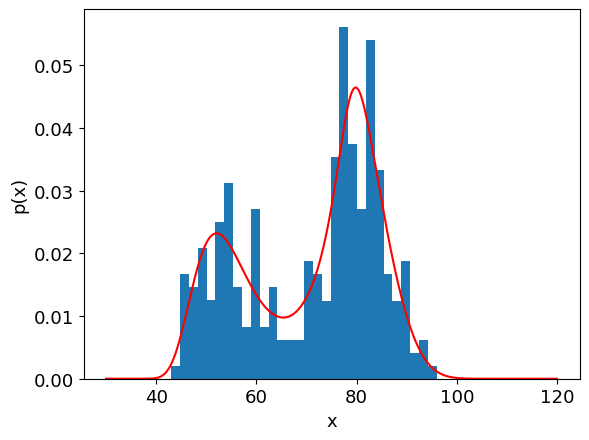

In [53]:
plt.hist(X, 30, density=True)
xs = np.linspace(30,120,500)
plt.plot(xs, dist.prob(xs), color="red")
plt.xlabel('x')
plt.ylabel('p(x)')

Text(0, 0.5, 'x')

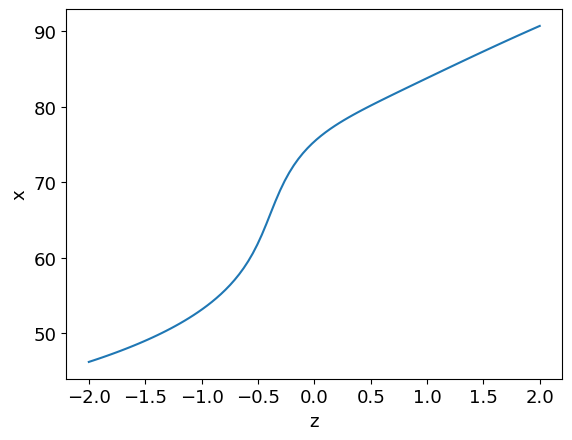

In [54]:
zz = np.linspace(-2, 2, 100)
plt.plot(zz, bijector.forward(zz))
plt.xlabel('z')
plt.ylabel('x')